<a href="https://colab.research.google.com/github/gmrwh92/covid/blob/main/Covid19_Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysing COVID-19 Data

# **Introduction**

In this portfolio, we are going to explore the global number of COVID-19.

Main Goal
* Comparing some countries based on their total confirmed COVID-19 cases
 - This is to see the total number number of confirmed cases in each countries.
* Comparing some countries after normalisaion
 - Larger countries have significantly larger populations compared to smaller countries; this factor is being considered in the calculation of confirmed cases per every 10 people.
* Build a model for prediction
  - ARIMA (statistical method for prediction based on historical time series) and LSTM (neural network for time series data prediction).
  - Compare the results between different size of dataset.



In [ ]:
!pip install pmdarima

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import torch
from tqdm import tqdm
from pylab import rcParams
import matplotlib.dates as mdates
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from datetime import datetime
from pmdarima.arima import auto_arima
from sklearn.model_selection import train_test_split

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

register_matplotlib_converters()

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# **Dataset for Covid**

Johns Hopkins University provides an open dataset that includes data on confirmed cases, deaths, and recovered cases. However, our focus is solely on the confirmed cases. The data is structured with one row per region, featuring columns for Latitude and Longitude, followed by separate columns for each day's data. This dataset has been collected since January 22, 2020, and is continuously updated.


In [ ]:
# load the live dataset,
covid_data_url = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
covid = pd.read_csv(covid_data_url)
covid

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,2/28/23,3/1/23,3/2/23,3/3/23,3/4/23,3/5/23,3/6/23,3/7/23,3/8/23,3/9/23
0,NaN,Afghanistan,33.939110,67.709953,0,0,0,0,0,0,...,209322,209340,209358,209362,209369,209390,209406,209436,209451,209451
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,334391,334408,334408,334427,334427,334427,334427,334427,334443,334457
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,271441,271448,271463,271469,271469,271477,271477,271490,271494,271496
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,47866,47875,47875,47875,47875,47875,47875,47875,47890,47890
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,105255,105277,105277,105277,105277,105277,105277,105277,105288,105288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284,NaN,West Bank and Gaza,31.952200,35.233200,0,0,0,0,0,0,...,703228,703228,703228,703228,703228,703228,703228,703228,703228,703228
285,NaN,Winter Olympics 2022,39.904200,116.407400,0,0,0,0,0,0,...,535,535,535,535,535,535,535,535,535,535
286,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,...,11945,11945,11945,11945,11945,11945,11945,11945,11945,11945
287,NaN,Zambia,-13.133897,27.849332,0,0,0,0,0,0,...,343012,343012,343079,343079,343079,343135,343135,343135,343135,343135


In [ ]:
## group our dataset by country and drop some variables that are not related to our analysis
grouped = covid.groupby('Country/Region').sum()
grouped = grouped.drop(columns=['Lat', 'Long'])
grouped = grouped.iloc[: , 1:]
grouped

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,2/28/23,3/1/23,3/2/23,3/3/23,3/4/23,3/5/23,3/6/23,3/7/23,3/8/23,3/9/23
Country/Region,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0,0,0,0,0,0,0,0,0,0,...,209322,209340,209358,209362,209369,209390,209406,209436,209451,209451
Albania,0,0,0,0,0,0,0,0,0,0,...,334391,334408,334408,334427,334427,334427,334427,334427,334443,334457
Algeria,0,0,0,0,0,0,0,0,0,0,...,271441,271448,271463,271469,271469,271477,271477,271490,271494,271496
Andorra,0,0,0,0,0,0,0,0,0,0,...,47866,47875,47875,47875,47875,47875,47875,47875,47890,47890
Angola,0,0,0,0,0,0,0,0,0,0,...,105255,105277,105277,105277,105277,105277,105277,105277,105288,105288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
West Bank and Gaza,0,0,0,0,0,0,0,0,0,0,...,703228,703228,703228,703228,703228,703228,703228,703228,703228,703228
Winter Olympics 2022,0,0,0,0,0,0,0,0,0,0,...,535,535,535,535,535,535,535,535,535,535
Yemen,0,0,0,0,0,0,0,0,0,0,...,11945,11945,11945,11945,11945,11945,11945,11945,11945,11945


## **Comparing countries**

* Comparing some random countries

<Axes: >

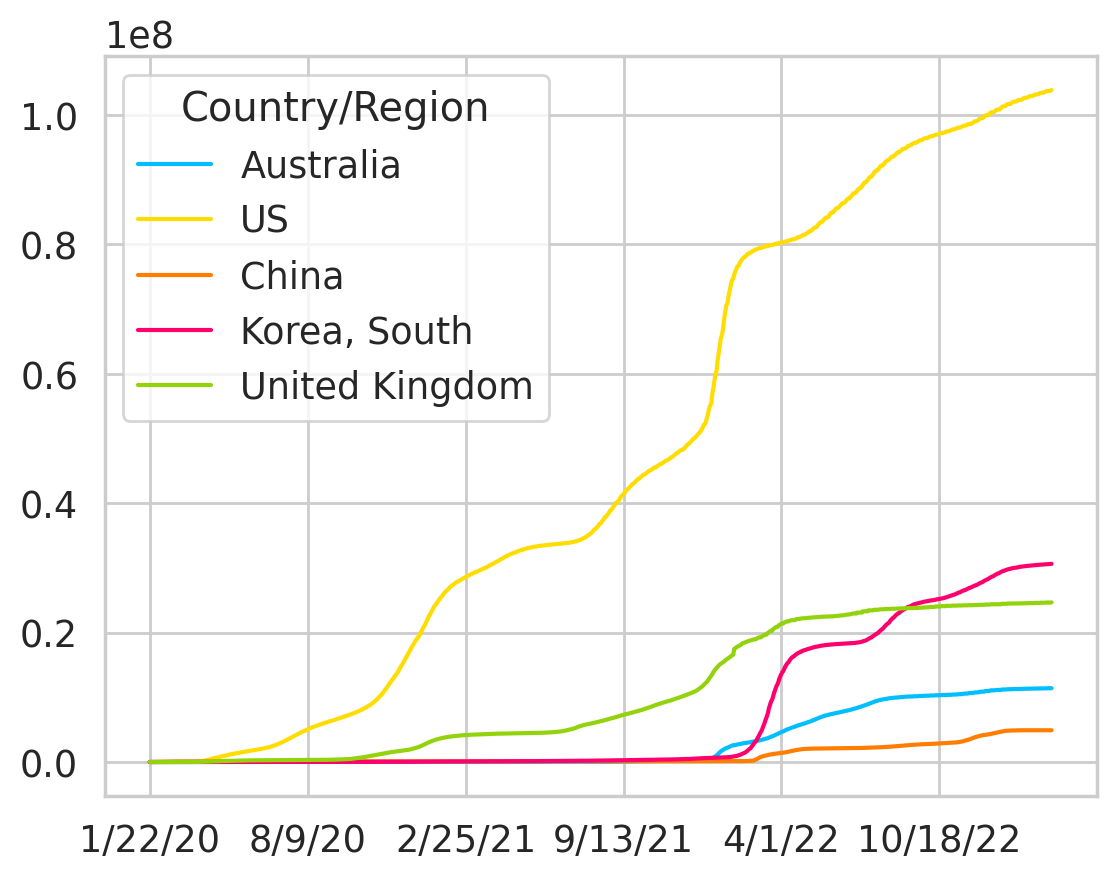

In [ ]:
## Produce a plot for "Australia", "US", "China", "Korea" and "United Kingdom"
aa = grouped.loc[["Australia","US","China","Korea, South", "United Kingdom"]]
aa.T.plot()

* Top 10 countries

In [ ]:
## Find top 10 countries
top = grouped.iloc[:,-1]
topp = top.nlargest(10)
display(topp)

,3/9/23
Country/Region,
US,103802702
India,44690738
France,39866718
Germany,38249060
Brazil,37076053
Japan,33320438
"Korea, South",30615522
Italy,25603510
United Kingdom,24658705


<Axes: >

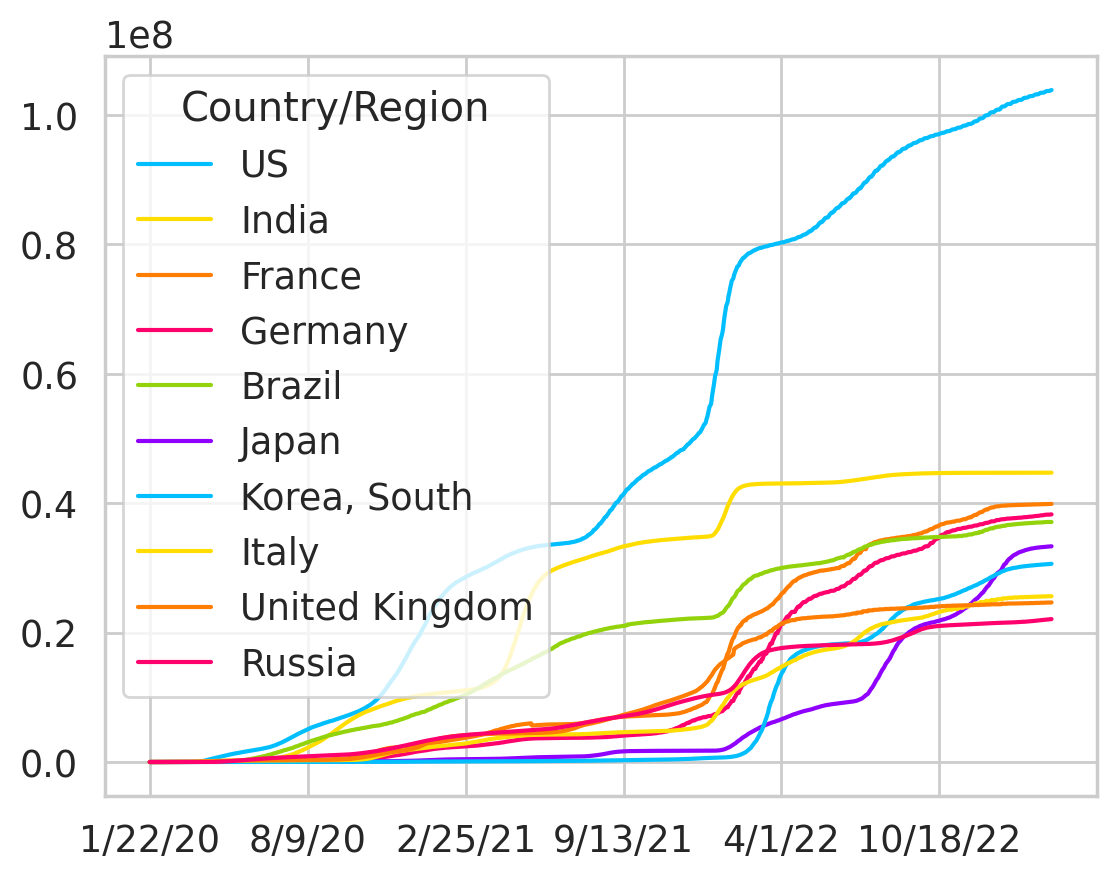

In [ ]:
## Plot for top 10 countries
toppp = grouped.loc[["US","India","France", "Germany", "Brazil", "Japan", "Korea, South", "Italy","United Kingdom", "Russia"]]
toppp.T.plot()

* Least 10 Countries

In [ ]:
## Find least 10 countries and make a plot
small = grouped.iloc[:,-1]
smalll = small.nsmallest(10)
display(smalll)

,3/9/23
Country/Region,
"Korea, North",1
MS Zaandam,9
Antarctica,11
Holy See,29
Winter Olympics 2022,535
Diamond Princess,712
Summer Olympics 2020,865
Tuvalu,2805
Kiribati,5014


<Axes: >

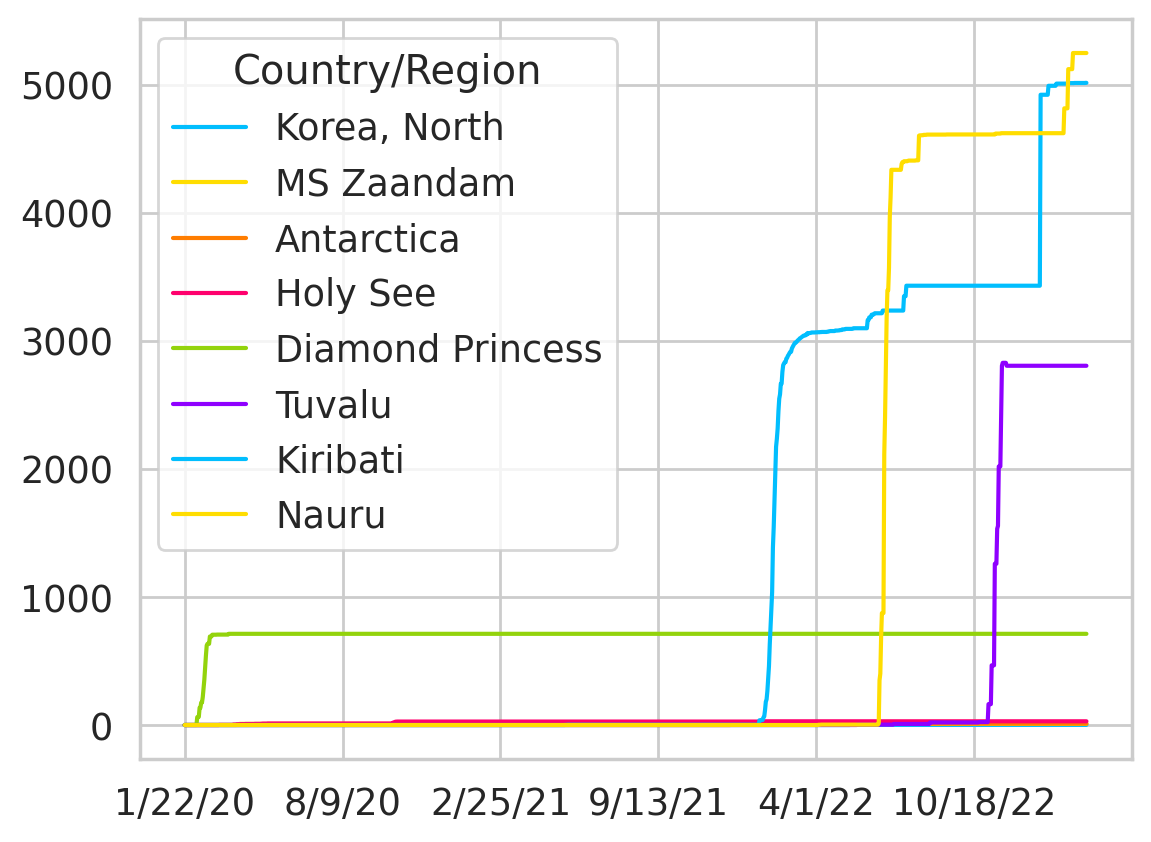

In [ ]:
## Plot for least 10 countries
smallll = grouped.loc[["Korea, North","MS Zaandam","Antarctica", "Holy See", "Diamond Princess", "Tuvalu", "Kiribati", "Nauru"]]
smallll.T.plot()

# **Dataset for population**

We obtained an open dataset from datahub.io containing population figures for various countries. This dataset covers the overall population of each country and spans from 1960 to 2016. In our COVID dataset, we have data for 186 countries, while the population dataset includes information on 263 countries. To ensure consistency, we manually adjusted the country names in our population dataset to match those in our COVID dataset. For instance, 'US' was changed to 'United States' to facilitate data compatibility between the two sets.

In [ ]:
## Read population dataset
population = pd.read_csv("/content/drive/MyDrive/population.csv", encoding = "ISO-8859-1")
population.head()

,Country,Country_Code,Year_1960,Year_1961,Year_1962,Year_1963,Year_1964,Year_1965,Year_1966,Year_1967,...,Year_2007,Year_2008,Year_2009,Year_2010,Year_2011,Year_2012,Year_2013,Year_2014,Year_2015,Year_2016
0,Aruba,ABW,54211.0,55438.0,56225.0,56695.0,57032.0,57360.0,57715.0,58055.0,...,101220.0,101353.0,101453.0,101669.0,102053.0,102577.0,103187.0,103795.0,104341.0,104822.0
1,Afghanistan,AFG,8996351.0,9166764.0,9345868.0,9533954.0,9731361.0,9938414.0,10152331.0,10372630.0,...,26616792.0,27294031.0,28004331.0,28803167.0,29708599.0,30696958.0,31731688.0,32758020.0,33736494.0,34656032.0
2,Angola,AGO,5643182.0,5753024.0,5866061.0,5980417.0,6093321.0,6203299.0,6309770.0,6414995.0,...,20997687.0,21759420.0,22549547.0,23369131.0,24218565.0,25096150.0,25998340.0,26920466.0,27859305.0,28813463.0
3,Albania,ALB,1608800.0,1659800.0,1711319.0,1762621.0,1814135.0,1864791.0,1914573.0,1965598.0,...,2970017.0,2947314.0,2927519.0,2913021.0,2905195.0,2900401.0,2895092.0,2889104.0,2880703.0,2876101.0
4,Andorra,AND,13411.0,14375.0,15370.0,16412.0,17469.0,18549.0,19647.0,20758.0,...,82683.0,83861.0,84462.0,84449.0,83751.0,82431.0,80788.0,79223.0,78014.0,77281.0


In [ ]:
## Get Country name and population in 2016 only
pop = population[['Country','Year_2016']]

## Change column name to merge with our covid dataset
popp = pop.rename(columns={"Country" : "Country/Region"})
poppp = popp.groupby('Country/Region').sum()

## Merge population and covid dataset
npp = pd.merge(poppp,grouped, how = 'inner', left_index=True, right_index=True)
npp.head()

,Year_2016,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,...,2/28/23,3/1/23,3/2/23,3/3/23,3/4/23,3/5/23,3/6/23,3/7/23,3/8/23,3/9/23
Country/Region,,,,,,,,,,,,,,,,,,,,,
Afghanistan,34656032.0,0,0,0,0,0,0,0,0,0,...,209322,209340,209358,209362,209369,209390,209406,209436,209451,209451
Albania,2876101.0,0,0,0,0,0,0,0,0,0,...,334391,334408,334408,334427,334427,334427,334427,334427,334443,334457
Algeria,40606052.0,0,0,0,0,0,0,0,0,0,...,271441,271448,271463,271469,271469,271477,271477,271490,271494,271496
Andorra,77281.0,0,0,0,0,0,0,0,0,0,...,47866,47875,47875,47875,47875,47875,47875,47875,47890,47890
Angola,28813463.0,0,0,0,0,0,0,0,0,0,...,105255,105277,105277,105277,105277,105277,105277,105277,105288,105288


In [ ]:
## Calculate confirmed cases per 10
npp = npp.iloc[:,-1]/npp['Year_2016'] * 10
npp

,0
Country/Region,
Afghanistan,0.060437
Albania,1.162883
Algeria,0.066861
Andorra,6.196866
Angola,0.036541
...,...
Vietnam,1.243458
West Bank and Gaza,1.545024
Yemen,0.004330


* Top 10 countries

<BarContainer object of 10 artists>

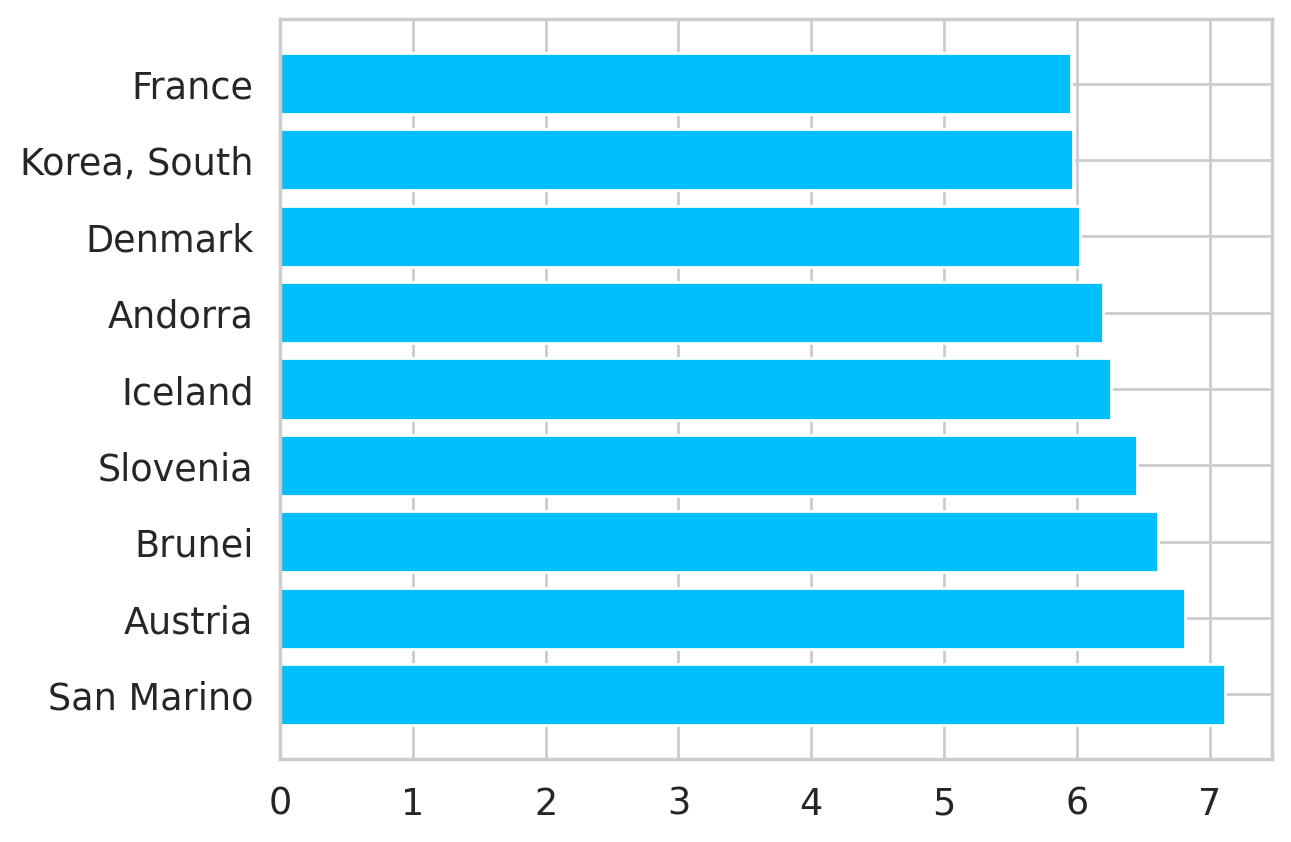

In [ ]:
## Find top 10 countries and plot
nptop = npp.nlargest(10)
plt.barh(nptop.index,nptop)

* Least 10 countries

<BarContainer object of 10 artists>

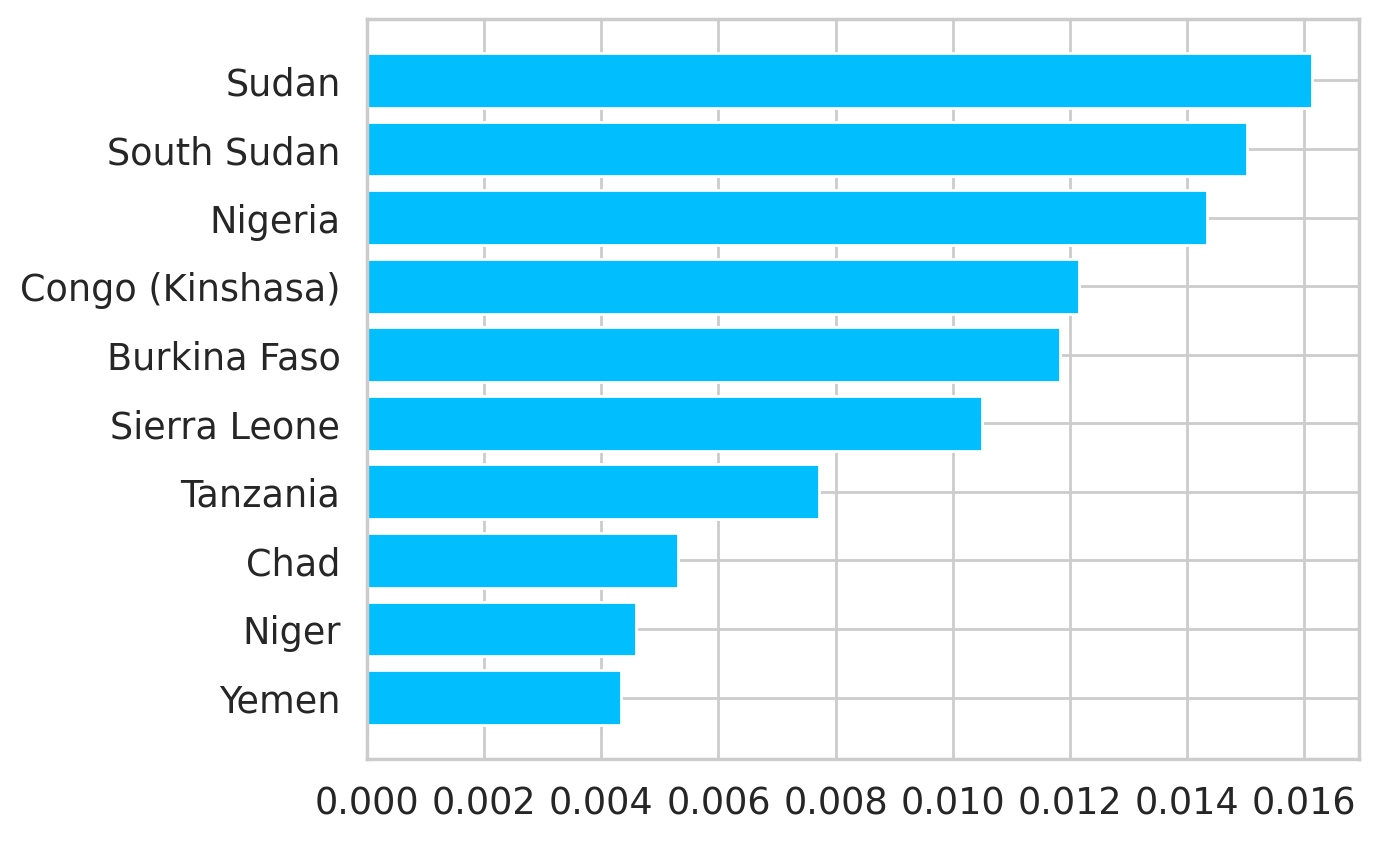

In [ ]:
## Find least 10 countries and plot
npsmall = npp.nsmallest(10)
plt.barh(npsmall.index,npsmall)

* We observe that 7 out of every 10 people in San Marino have tested positive for COVID-19. While the US has the highest number of confirmed cases overall, San Marino leads in cases per capita. It's important to note that we cannot definitively conclude whether the US or San Marino has been more severely affected by COVID-19. This analysis provides a quick insight into the statistics.

# **Predictions**
The live dataset provides cumulative numbers, but our plan is to calculate new daily cases for predictions in Korea. We will split these new daily cases into a training set and a test set for validation.The dataset spans 1,143 days, with 80% of the data allocated to the training set.


Firstly, we will predict the number of daily cases from from 1st Feb 2023 to 9th March 2023 based on the historical data from Oct 2022 to Jan 2023.

Secondly, we will train the model using data from January 22, 2020, to July 31, 2022 (80% of entire dataset). Then, we will validate the model by comparing actual and predicted data from August 1, 2023, to March 9, 2023 (20%).

Finally, we will provide insights based on the results of both models to see how the size of the dataset could affect the results.

### **Data pre-processing**


In [ ]:
grouped = covid.groupby('Country/Region').sum()
grouped = grouped.drop(columns=['Lat', 'Long'])
grouped = grouped.iloc[: , 1:]

In [ ]:
## Extract the data for Korea
grouped = grouped.loc[["Korea, South"]]
total_cases = grouped.sum(axis=0)
total_cases.index = pd.to_datetime(total_cases.index)
total_cases

<ipython-input-17-bdbfd2b8400d>:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  total_cases.index = pd.to_datetime(total_cases.index)


,0
2020-01-22,1
2020-01-23,1
2020-01-24,2
2020-01-25,2
2020-01-26,3
...,...
2023-03-05,30569215
2023-03-06,30581499
2023-03-07,30594297
2023-03-08,30605187


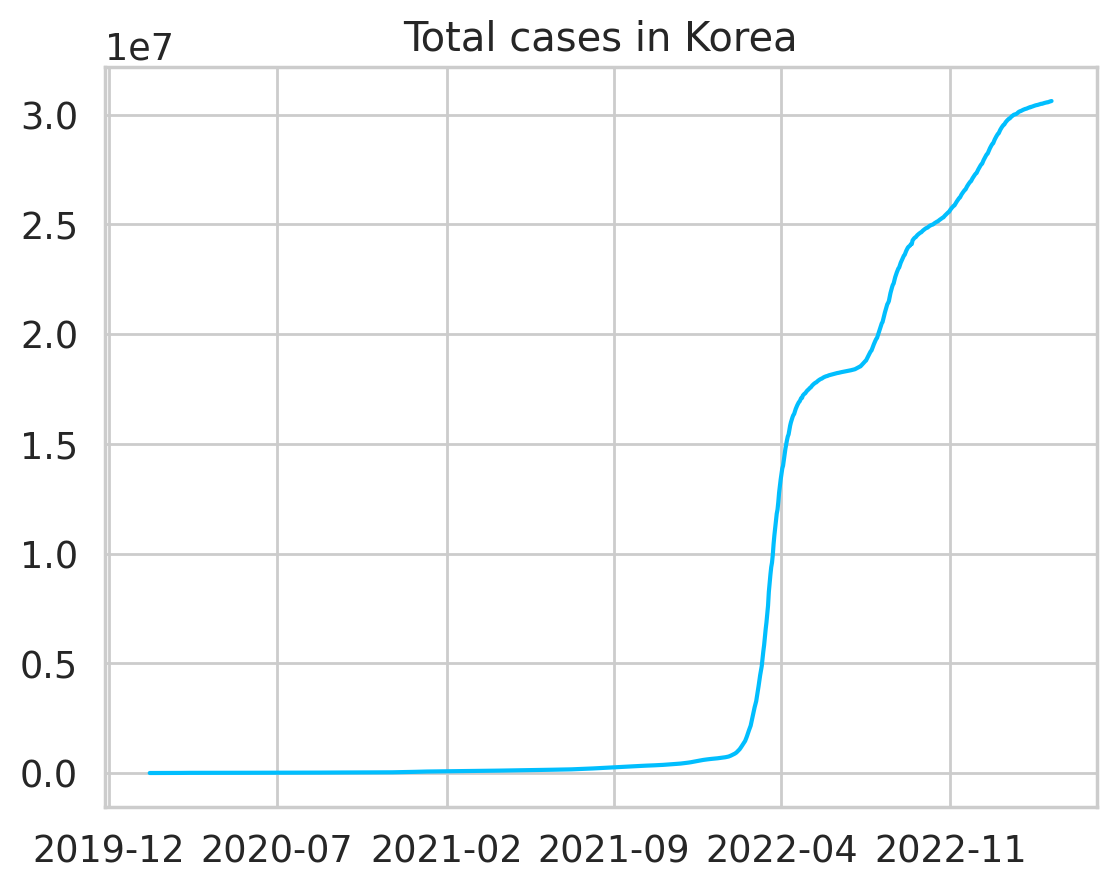

In [ ]:
## total number of cases in Korea since 2020
ax = plt.gca()
plt.plot(total_cases)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=7))
plt.title("Total cases in Korea");

* We will subtract the number of cases on the current date from those on the previous date to calculate the daily new cases

In [ ]:
daily_cases = total_cases.diff().fillna(total_cases[0]).astype(np.int64)
daily_cases

<ipython-input-19-b0862518b619>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  daily_cases = total_cases.diff().fillna(total_cases[0]).astype(np.int64)


,0
2020-01-22,1
2020-01-23,0
2020-01-24,1
2020-01-25,0
2020-01-26,1
...,...
2023-03-05,14113
2023-03-06,12284
2023-03-07,12798
2023-03-08,10890


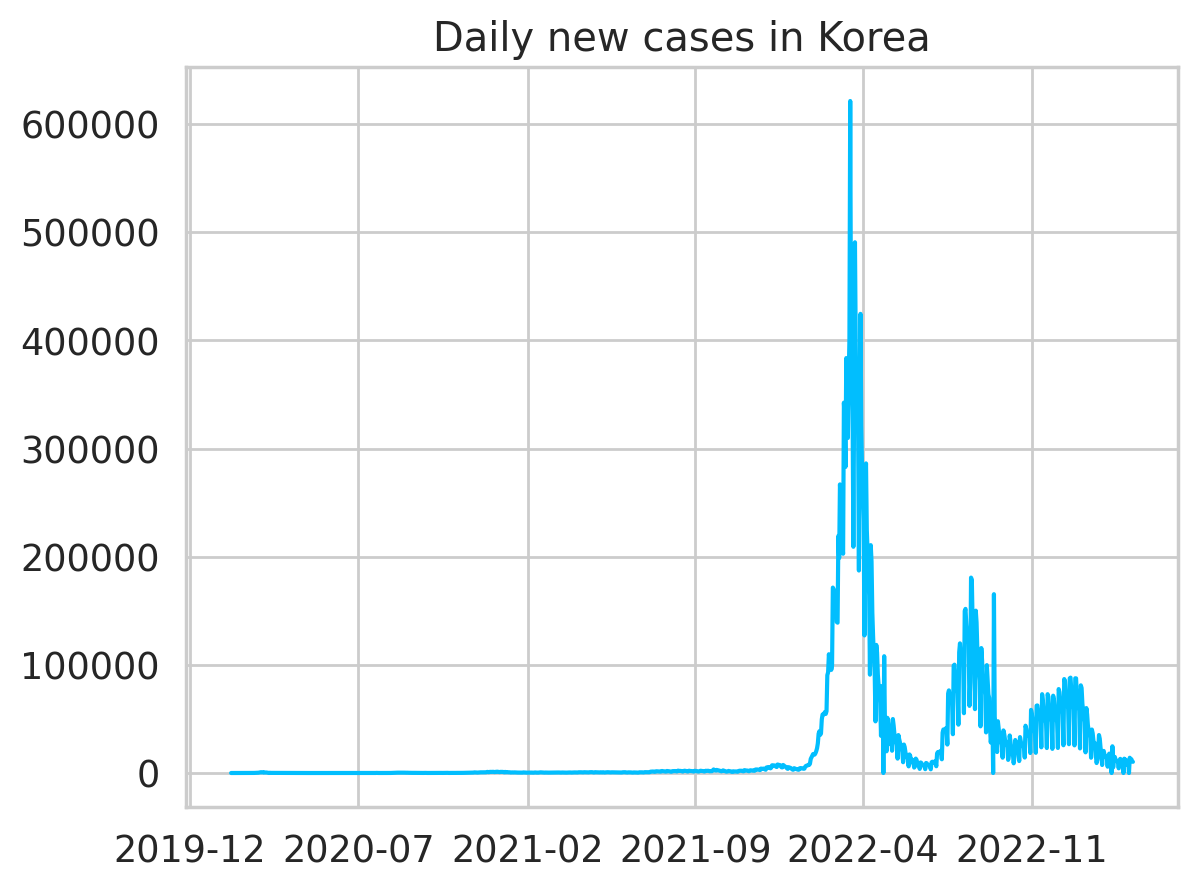

In [ ]:
## plot daily cases
ax = plt.gca()
plt.plot(daily_cases)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=7))
plt.title("Daily new cases in Korea");

* This plot could provide insight into the peak of COVID-19 spread in Korea.

 What we want to do is that we build a model to predict the daily cases from 1st Feb 2023 to 9th March 2023 based on the historical data from Oct 2022 to Jan 2023

In [ ]:
## split data into train and test set
daily_cases.index = pd.to_datetime(daily_cases.index)
test_data = daily_cases[-37:]
daily_cases.drop(daily_cases.tail(37).index, inplace = True)
train_data = daily_cases.iloc[-123:]
test_data1 = test_data

In [ ]:
train_data

,0
2022-10-01,23597
2022-10-02,12150
2022-10-03,16423
2022-10-04,34710
2022-10-05,28603
...,...
2023-01-27,23367
2023-01-28,18871
2023-01-29,7416
2023-01-30,19629


In [ ]:
test_data

,0
2023-02-01,16862
2023-02-02,14961
2023-02-03,14504
2023-02-04,14018
2023-02-05,5850
2023-02-06,16120
2023-02-07,17934
2023-02-08,14664
2023-02-09,13504
2023-02-10,0


In [ ]:
logtrain_data = np.log1p(train_data)
logtest_data = np.log1p(test_data)

### **ARIMA Model**

* Test for Stationarity before building ARIMA

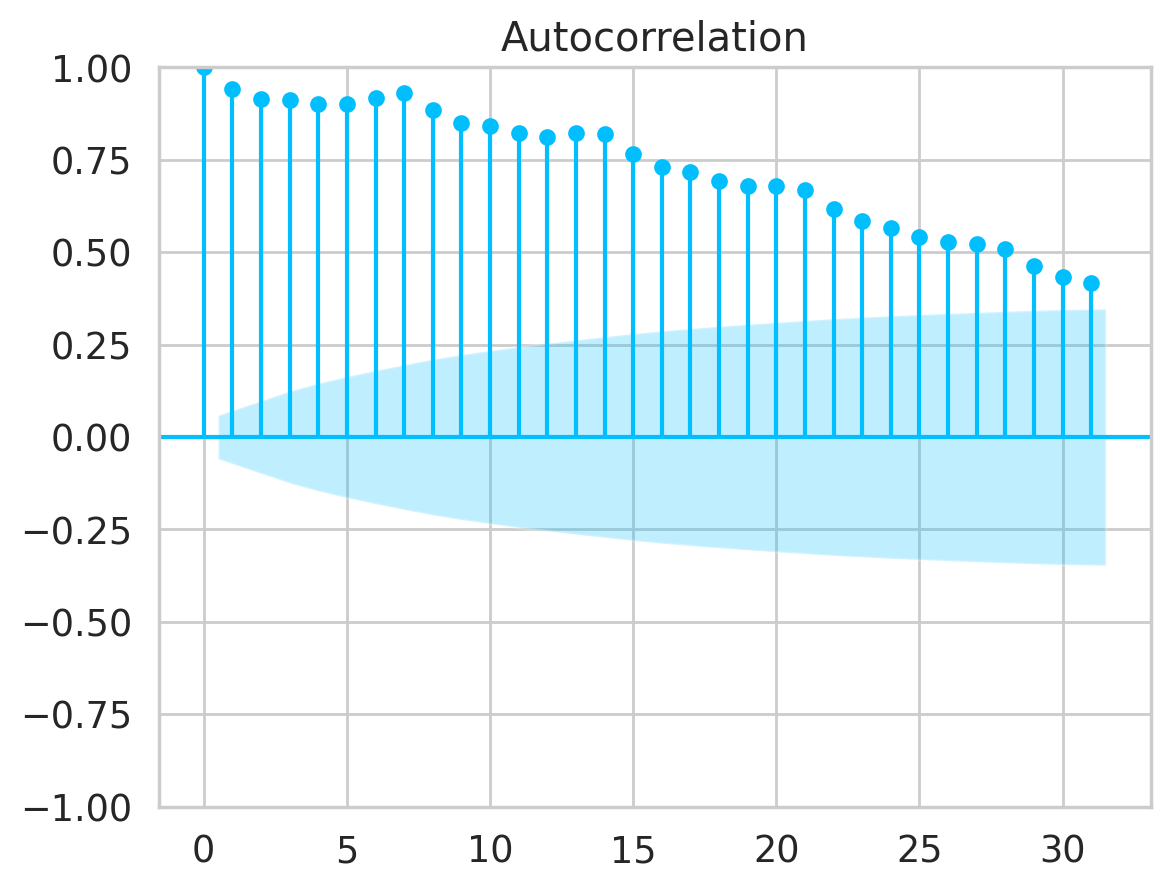

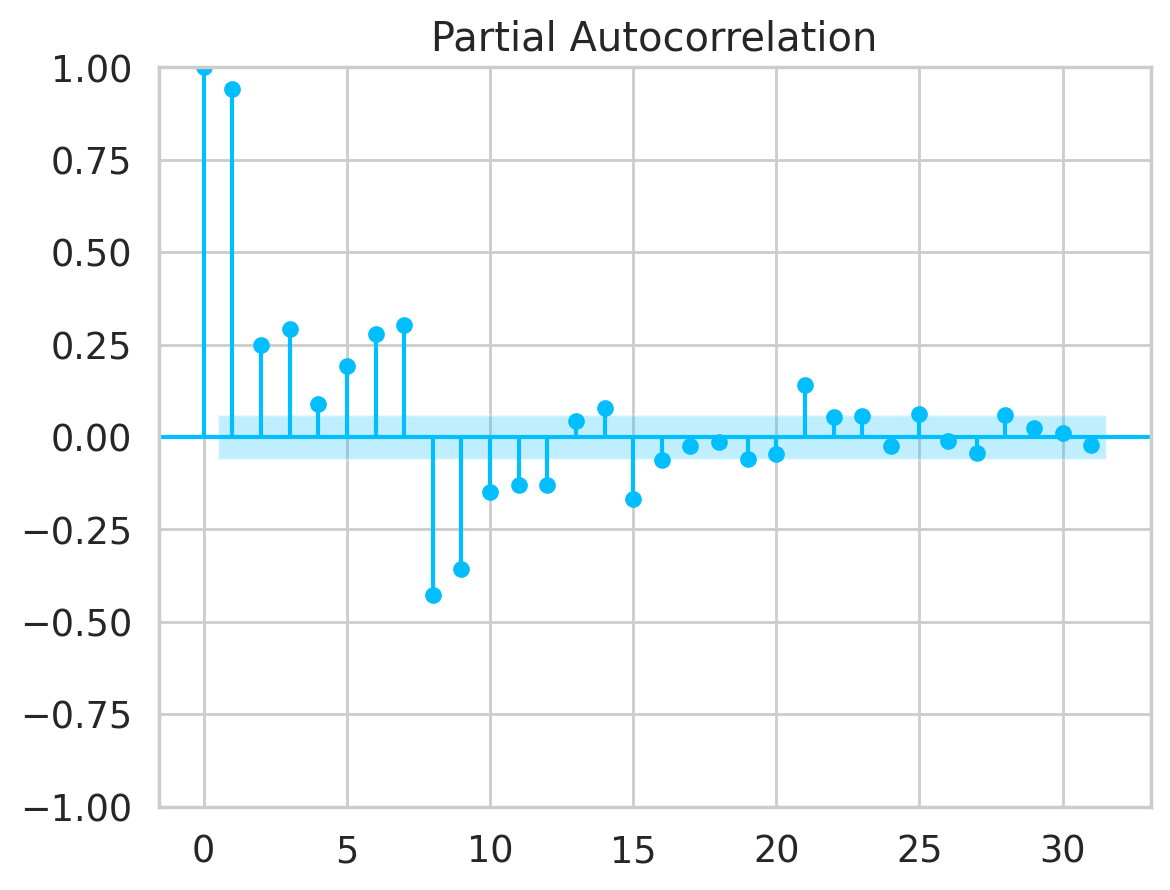

In [ ]:
## Autocorrelation Function (ACF) and Partial Autorreclation Function (PACF)
plot_acf(daily_cases)
plot_pacf(daily_cases)
plt.show()

In [ ]:
## Augmented Dicky-Fullter Test
result = adfuller(daily_cases)

print('ADF statistics: %f' % result[0])
print('p-value %f' % result[1])
print('Critical values')
for key, value in result[4].items():
  print('\t%s: %3f' % (key,value))

ADF statistics: -3.942829
p-value 0.001741
Critical values
	1%: -3.436403
	5%: -2.864212
	10%: -2.568193


* All ACF, PACF, and ADF tests indicate that our dataset is stationary. ACF values drop off quickly, PACF values approach 0, and the p-value from the ADF test is less than 0.05. These results collectively confirm the stationarity of the time series in this dataset.

In [ ]:
## find the optimal p(AR specification), d(Integer order), q(MA specification)
model = auto_arima(train_data, start_p=1, start_q=1,
                      test='adf',
                      max_p=5, max_q=5,
                      m=1,
                      d=1,
                      seasonal=False,
                      start_P=0,
                      D=None,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

Performing stepwise search to minimize aic


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2714.231, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2756.464, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2744.115, Time=0.05 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2713.945, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2754.468, Time=0.04 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2712.247, Time=0.29 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.76 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.85 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2702.480, Time=3.12 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2691.882, Time=1.54 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=7.03 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=2690.041, Time=1.88 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=3.47 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=2688.382, Time=1.81 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.66 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=2653.626, Time=3.20 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.51 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,4)(0,0,0)[0] intercept   : AIC=2674.614, Time=0.69 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,4)(0,0,0)[0] intercept   : AIC=2693.493, Time=0.74 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,3)(0,0,0)[0]             : AIC=2651.632, Time=0.68 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,3)(0,0,0)[0]             : AIC=2686.384, Time=0.32 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,2)(0,0,0)[0]             : AIC=inf, Time=0.60 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,4)(0,0,0)[0]             : AIC=2672.583, Time=0.63 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,2)(0,0,0)[0]             : AIC=inf, Time=0.48 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,4)(0,0,0)[0]             : AIC=2691.454, Time=0.60 sec

Best model:  ARIMA(5,1,3)(0,0,0)[0]          
Total fit time: 33.718 seconds


* Fit model


In [ ]:
## we fit a model, p(AR specification) = 5, d(Integer order) = 1, q(MA specification) = 3 based on best model selection
model = ARIMA(train_data, order=(5,2,4))
model_fit = model.fit()

## set up the date period we want to forecast
start_index = datetime(2023, 2, 1)
end_index = datetime(2023, 3, 9)
forecast= model_fit.predict(start = start_index, end=end_index, typ='levels')


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unkn

In [ ]:
forecast.head(15)

,predicted_mean
2023-02-01,29094.112078
2023-02-02,21773.218631
2023-02-03,17559.016926
2023-02-04,31826.482662
2023-02-05,18572.182933
2023-02-06,22430.718716
2023-02-07,20145.312698
2023-02-08,25383.645303
2023-02-09,19512.105033
2023-02-10,15766.639575


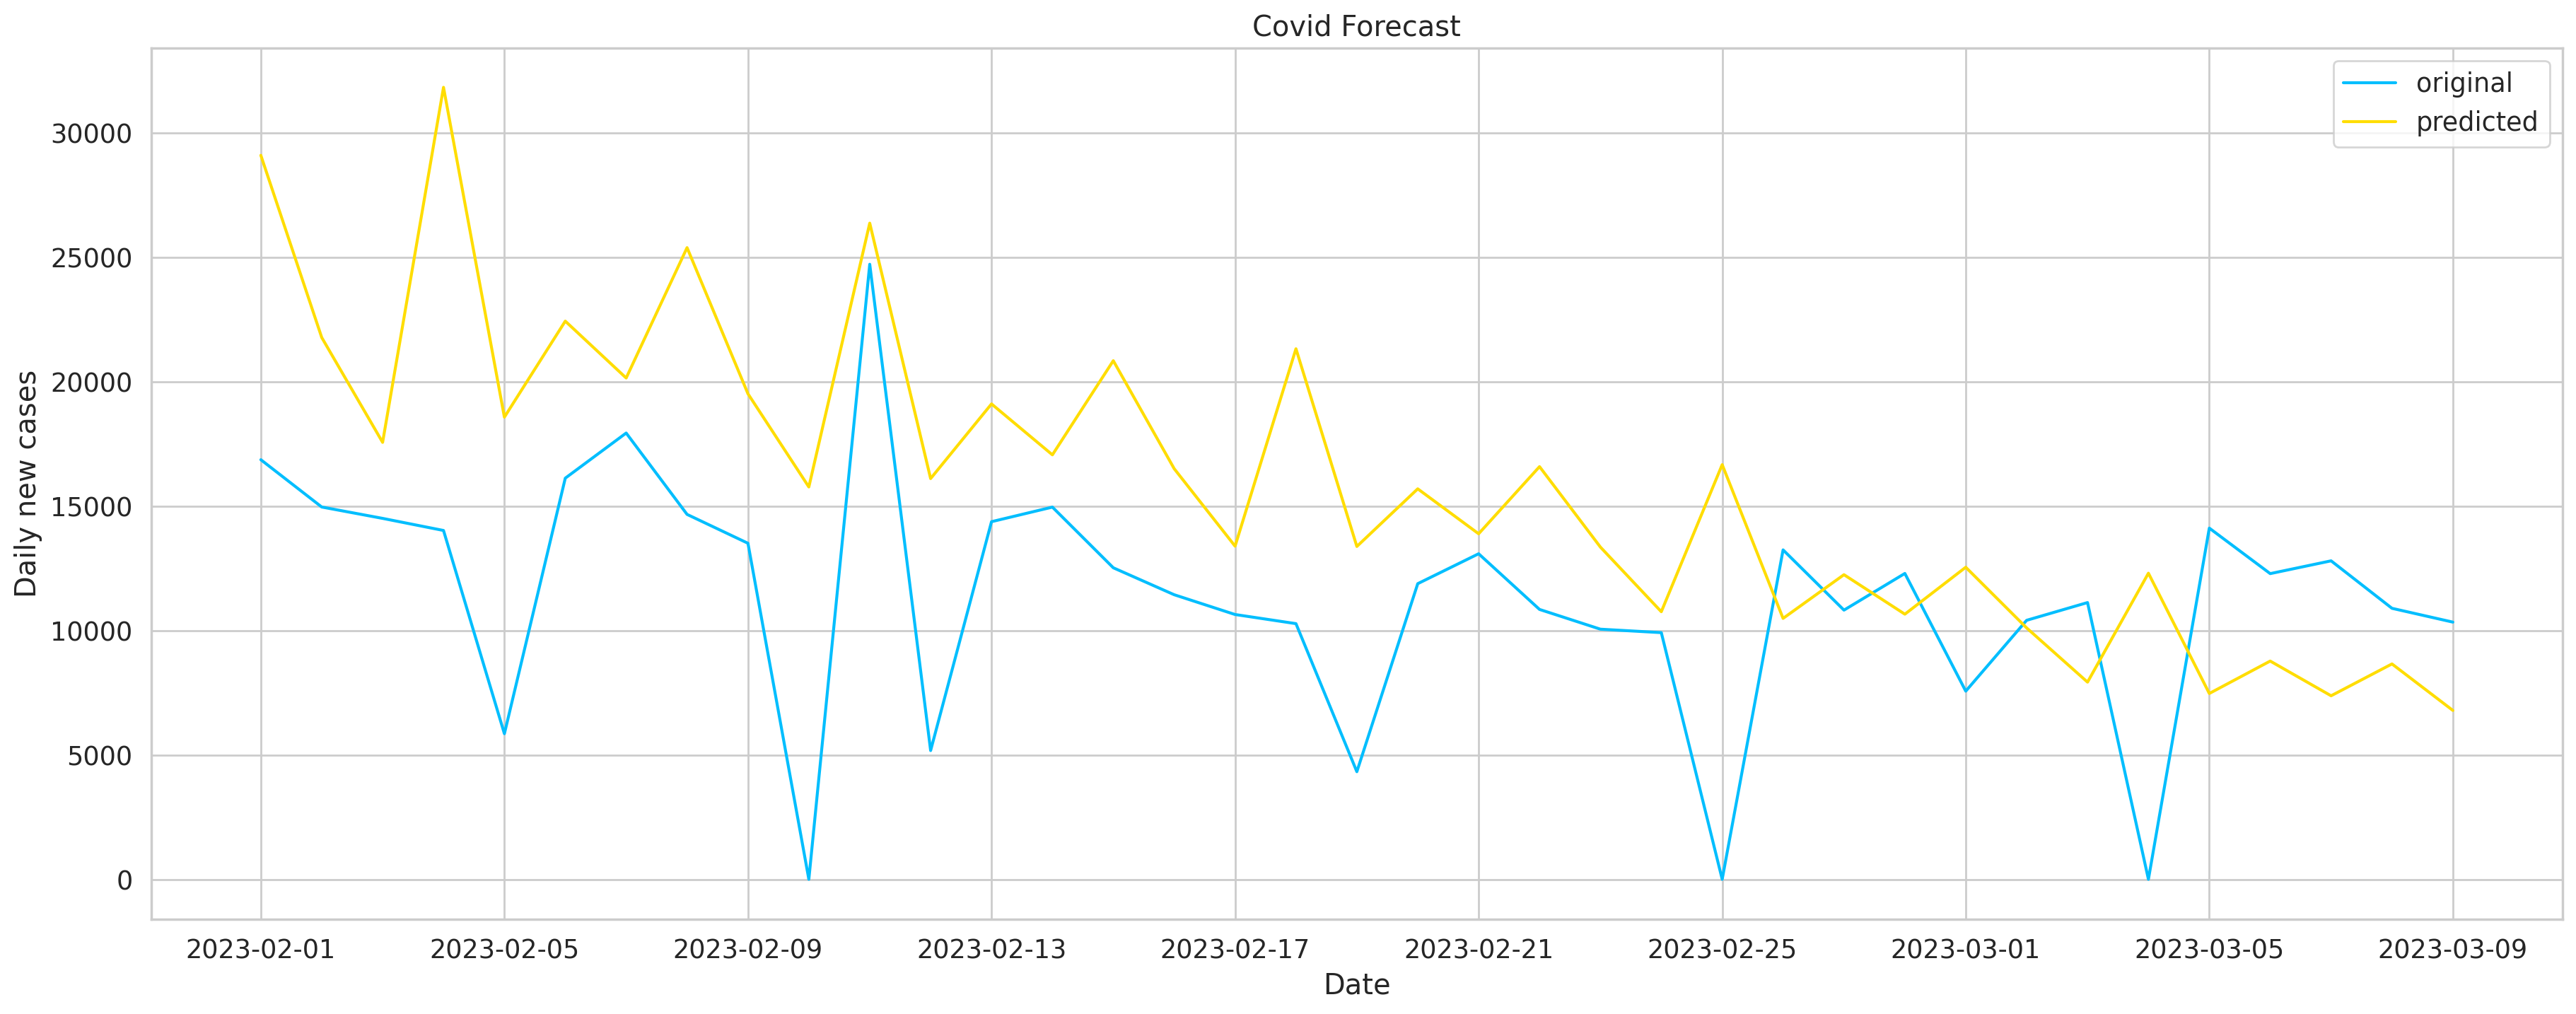

In [ ]:
##plot the real cases vs predicted cases based on ARIMA

plt.figure(figsize=(22,8))
plt.plot(test_data, label="original")
plt.plot(forecast,label = "predicted")
plt.title("Covid Forecast")
plt.xlabel("Date")
plt.ylabel("Daily new cases")
plt.legend()
plt.show()

### **LSTM (Long Short-Term Memory), Deep Learning**

In [ ]:
daily_cases = total_cases.diff().fillna(total_cases[0]).astype(np.int64)
daily_cases = daily_cases[-160:]

<ipython-input-31-f0a1587e411c>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  daily_cases = total_cases.diff().fillna(total_cases[0]).astype(np.int64)


In [ ]:
test_data_size = 37

train_data = daily_cases[:-test_data_size]
test_data = daily_cases[-test_data_size:]

train_data.shape
test_data.shape

(37,)

In [ ]:
logtrain_data = np.log1p(train_data)
logtest_data = np.log1p(test_data)

In [ ]:
## Scale the dataset to increase the training speed
scaler = MinMaxScaler()

scaler = scaler.fit(np.expand_dims(train_data, axis=1))

train_data = scaler.transform(np.expand_dims(train_data, axis=1))

test_data = scaler.transform(np.expand_dims(test_data, axis=1))

In [ ]:
## Convert dataset into smaller periods
def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

In [ ]:
seq_length = 5
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()


In [ ]:
## define model
class LSTM(nn.Module):

  def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
    super(LSTM, self).__init__()

    self.n_hidden = n_hidden
    self.seq_len = seq_len
    self.n_layers = n_layers

    self.lstm = nn.LSTM(
      input_size=n_features,
      hidden_size=n_hidden,
      num_layers=n_layers,
      dropout=0.2
    )

    self.linear = nn.Linear(in_features=n_hidden, out_features=1)

  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
    )

  def forward(self, sequences):
    lstm_out, self.hidden = self.lstm(
      sequences.view(len(sequences), self.seq_len, -1),
      self.hidden
    )
    last_time_step = \
      lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
    y_pred = self.linear(last_time_step)
    return y_pred


In [ ]:
## define training
def train_model(
  model,
  train_data,
  train_labels,
  test_data=None,
  test_labels=None
):
  loss_fn = torch.nn.MSELoss(reduction='sum')

  optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)
  num_epochs = 100

  train_hist = np.zeros(num_epochs)
  test_hist = np.zeros(num_epochs)

  for t in range(num_epochs):
    model.reset_hidden_state()

    y_pred = model(X_train)

    loss = loss_fn(y_pred.float(), y_train)

    if test_data is not None:
      with torch.no_grad():
        y_test_pred = model(X_test)
        test_loss = loss_fn(y_test_pred.float(), y_test)
      test_hist[t] = test_loss.item()

      if t % 10 == 0:
        print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
    elif t % 10 == 0:
      print(f'Epoch {t} train loss: {loss.item()}')

    train_hist[t] = loss.item()

    optimiser.zero_grad()

    loss.backward()

    optimiser.step()

  return model.eval(), train_hist, test_hist

In [ ]:
##train
model = LSTM(
  n_features=1,
  n_hidden=512,
  seq_len=seq_length,
  n_layers=5
)
model, train_hist, test_hist = train_model(
  model,
  X_train,
  y_train,
  X_test,
  y_test
)


Epoch 0 train loss: 32.05971145629883 test loss: 0.15150389075279236
Epoch 10 train loss: 8.433331489562988 test loss: 4.790371417999268
Epoch 20 train loss: 8.324441909790039 test loss: 4.890539646148682
Epoch 30 train loss: 8.269800186157227 test loss: 5.1330695152282715
Epoch 40 train loss: 8.206090927124023 test loss: 5.476497650146484
Epoch 50 train loss: 8.364750862121582 test loss: 4.96078634262085
Epoch 60 train loss: 8.16844654083252 test loss: 5.8949127197265625
Epoch 70 train loss: 7.737330436706543 test loss: 9.280546188354492
Epoch 80 train loss: 14.02966022491455 test loss: 1.2758889198303223
Epoch 90 train loss: 9.585531234741211 test loss: 3.3403310775756836


In [ ]:
## predict
with torch.no_grad():
  test_seq = X_test[:1]
  preds = []
  for _ in range(len(X_test)):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [ ]:
## convert scaled values into the original
true_cases = scaler.inverse_transform(
    np.expand_dims(y_test.flatten().numpy(), axis=0)
).flatten()

predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

In [ ]:
predicted_cases

array([50123.51369977, 49126.82025909, 48790.10138845, 48803.99776864,
       48922.32157111, 48994.68671823, 48954.31164479, 48827.00116348,
       48693.32251072, 48620.05243826, 48620.20646811, 48662.44915342,
       48705.7748611 , 48726.67478585, 48724.68202472, 48712.18635345,
       48701.49571943, 48697.95303297, 48700.18165231, 48704.09497309,
       48706.57870436, 48706.84344316, 48705.7604208 , 48704.59557009,
       48704.07571936, 48704.20086861, 48704.59075665, 48704.89881635,
       48704.98545814, 48704.89881635, 48704.76885366])

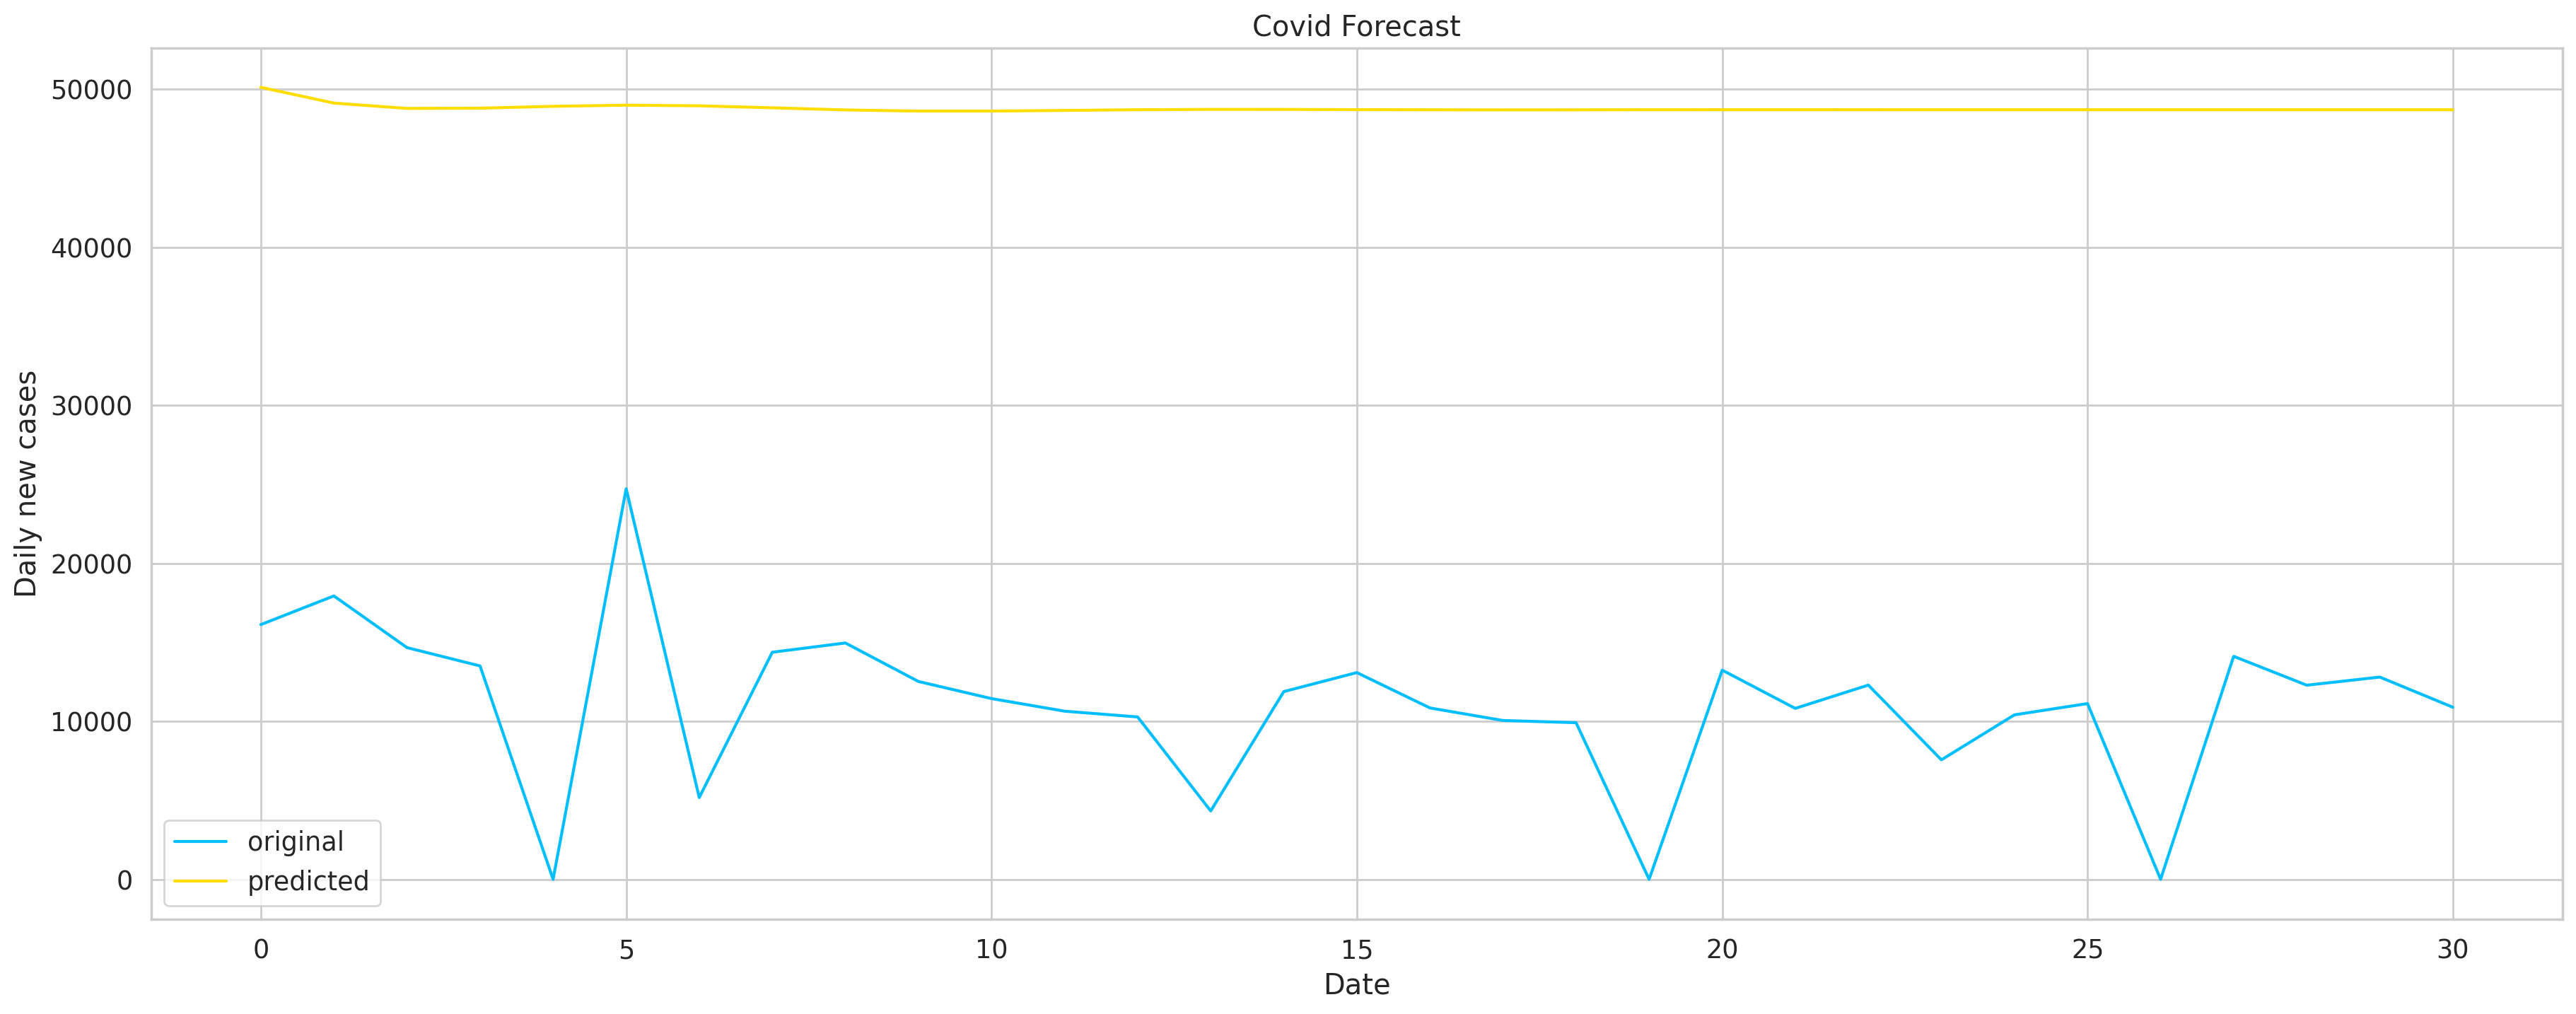

In [ ]:
## plot real cases vs predicted cases based on LSTM
plt.figure(figsize=(22,8))
plt.plot(true_cases, label="original")
plt.plot(predicted_cases,label = "predicted")
plt.title("Covid Forecast")
plt.xlabel("Date")
plt.ylabel("Daily new cases")
plt.legend()
plt.show()

### **Evaluation Arima vs LSTM vs Raw data**

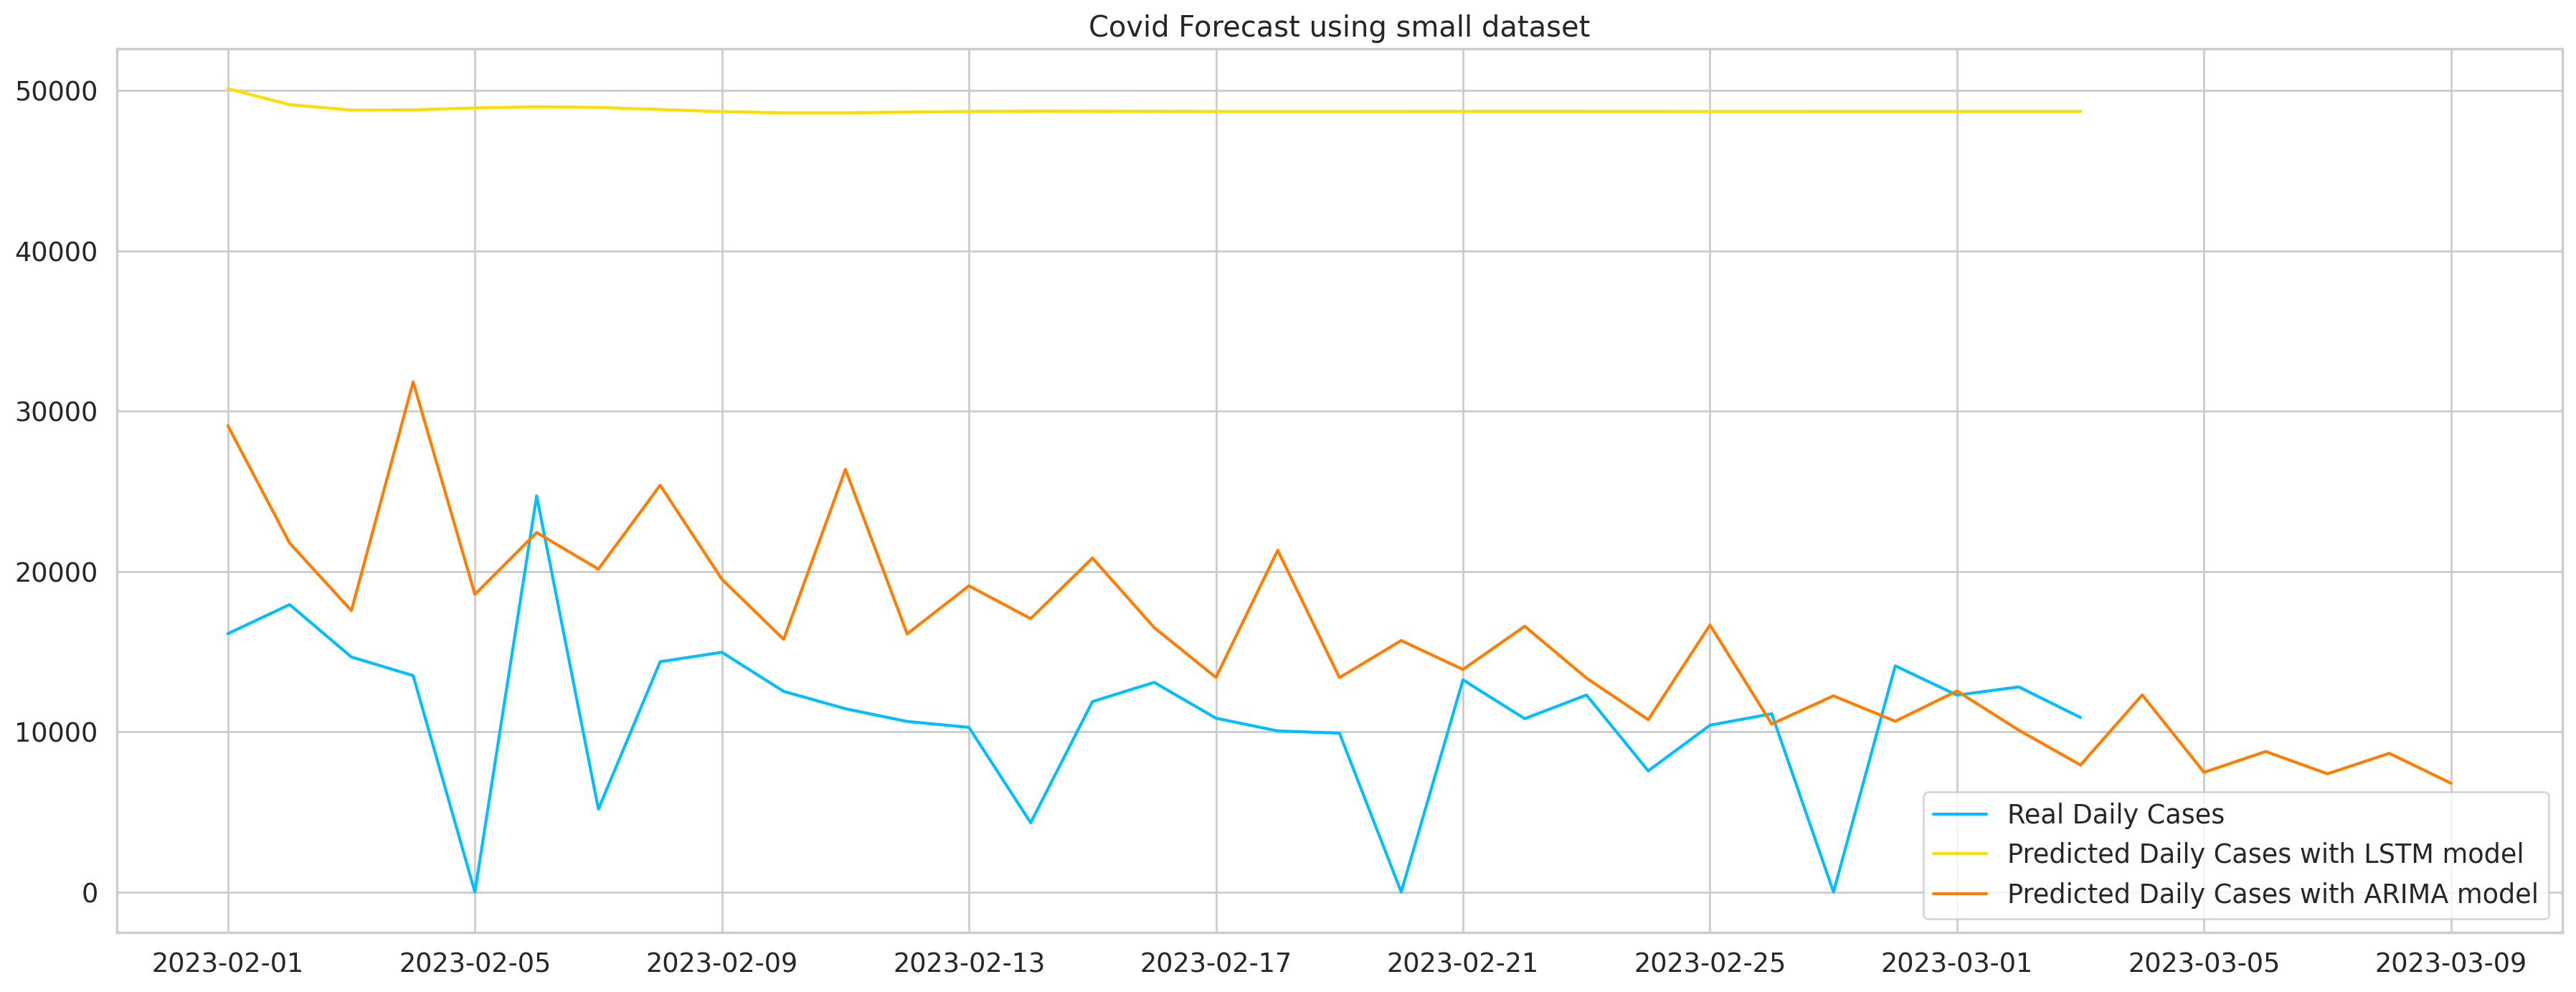

In [ ]:
plt.figure(figsize=(22,8))
plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(true_cases)],
  true_cases,
  label='Real Daily Cases'
)

plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(true_cases)],
  predicted_cases,
  label='Predicted Daily Cases with LSTM model'
)

plt.plot(forecast,label = "Predicted Daily Cases with ARIMA model")

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=7))
plt.title("Covid Forecast using small dataset")
plt.legend()

In [ ]:
## evaluation criteria
def MAE(true, pred):
    return np.mean(np.abs(true-pred))

In [ ]:
## MAE for LSTM model
MAE(true_cases, predicted_cases)

37762.64595194496

In [ ]:
## MAE for ARIMA model
MAE(np.array(test_data1), np.array(forecast))

6173.292463000646

* Both the Arima (statistical) and LSTM (deep learning) models do not perform well, ARIMA outperforming LSTM

## **Using Entire dataset(80% training and 20% test)**

In [ ]:
## split data into train and test set
daily_cases = total_cases.diff().fillna(total_cases[0]).astype(np.int64)
daily_cases.index = pd.to_datetime(daily_cases.index)
test_data = daily_cases[-221:]
daily_cases.drop(daily_cases.tail(221).index, inplace = True)
train_data = daily_cases
test_data1 = test_data

<ipython-input-48-c8540eb23924>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  daily_cases = total_cases.diff().fillna(total_cases[0]).astype(np.int64)


In [ ]:
train_data

,0
2020-01-22,1
2020-01-23,0
2020-01-24,1
2020-01-25,0
2020-01-26,1
...,...
2022-07-27,88296
2022-07-28,85275
2022-07-29,81944
2022-07-30,73589


In [ ]:
test_data

,0
2022-08-01,111700
2022-08-02,119866
2022-08-03,107849
2022-08-04,112857
2022-08-05,110610
...,...
2023-03-05,14113
2023-03-06,12284
2023-03-07,12798
2023-03-08,10890


### ***ARIMA with entire dataset***

In [ ]:
## find the optimal p(AR specification), d(Integer order), q(MA specification)
model = auto_arima(train_data, start_p=1, start_q=1,
                      test='adf',
                      max_p=5, max_q=5,
                      m=1,
                      d=1,
                      seasonal=False,
                      start_P=0,
                      D=None,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=20770.664, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=20919.537, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=20871.898, Time=0.06 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=20799.582, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=20917.543, Time=0.04 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=20744.788, Time=0.42 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=20780.068, Time=0.15 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=20746.772, Time=0.47 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=20733.845, Time=0.81 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=20731.174, Time=0.50 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=20750.358, Time=0.23 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=20633.489, Time=0.63 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=20734.049, Time=0.42 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=20563.446, Time=5.12 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=20564.406, Time=1.88 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=2.89 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=20633.115, Time=1.03 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=20736.623, Time=0.98 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=3.86 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,0,0)[0]             : AIC=20561.490, Time=4.23 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(0,0,0)[0]             : AIC=20630.219, Time=0.54 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,0)[0]             : AIC=20731.813, Time=1.21 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,3)(0,0,0)[0]             : AIC=20562.468, Time=3.14 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,4)(0,0,0)[0]             : AIC=inf, Time=6.55 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[0]             : AIC=20729.191, Time=2.02 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,4)(0,0,0)[0]             : AIC=20629.966, Time=1.15 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,0,0)[0]             : AIC=20734.596, Time=0.78 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,4)(0,0,0)[0]             : AIC=inf, Time=2.85 sec

Best model:  ARIMA(2,1,3)(0,0,0)[0]          
Total fit time: 42.503 seconds


In [ ]:
## we fit a model, p(AR specification) = 2, d(Integer order) = 1, q(MA specification) = 3 based on best model selection
model = ARIMA(train_data, order=(2,1,3))
model_fit = model.fit()

## set up the date period we want to forecast
start_index = datetime(2022, 8, 1)
end_index = datetime(2023, 3, 9)
forecast = model_fit.predict(start = start_index, end=end_index, typ='levels')

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


### ***LSTM with entire dataset***

In [ ]:
daily_cases = total_cases.diff().fillna(total_cases[0]).astype(np.int64)
test_data_size = 221

train_data = daily_cases[:-test_data_size]
test_data = daily_cases[-test_data_size:]

train_data.shape

<ipython-input-53-e4add1a8a606>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  daily_cases = total_cases.diff().fillna(total_cases[0]).astype(np.int64)


(922,)

In [ ]:
scaler = scaler.fit(np.expand_dims(train_data, axis=1))

train_data = scaler.transform(np.expand_dims(train_data, axis=1))

test_data = scaler.transform(np.expand_dims(test_data, axis=1))

In [ ]:
## set up different sequence as our size of data has increased
seq_length = 30
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [ ]:
##train
model = LSTM(
  n_features=1,
  n_hidden=128,
  seq_len=seq_length,
  n_layers=2
)
model, train_hist, test_hist = train_model(
  model,
  X_train,
  y_train,
  X_test,
  y_test
)

Epoch 0 train loss: 19.779972076416016 test loss: 3.3567326068878174
Epoch 10 train loss: 10.95148754119873 test loss: 0.5583958625793457
Epoch 20 train loss: 10.871028900146484 test loss: 0.4677776098251343
Epoch 30 train loss: 10.867425918579102 test loss: 0.41689303517341614
Epoch 40 train loss: 10.845418930053711 test loss: 0.5052701830863953
Epoch 50 train loss: 10.84316349029541 test loss: 0.42507311701774597
Epoch 60 train loss: 10.814752578735352 test loss: 0.481048583984375
Epoch 70 train loss: 10.789752960205078 test loss: 0.45134618878364563
Epoch 80 train loss: 10.758853912353516 test loss: 0.4659617245197296
Epoch 90 train loss: 10.6910982131958 test loss: 0.45963189005851746


In [ ]:
## predict
with torch.no_grad():
  test_seq = X_test[:1]
  preds = []
  for _ in range(len(X_test)):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [ ]:
## convert scaled values into the original
true_cases = scaler.inverse_transform(
    np.expand_dims(y_test.flatten().numpy(), axis=0)
).flatten()

predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

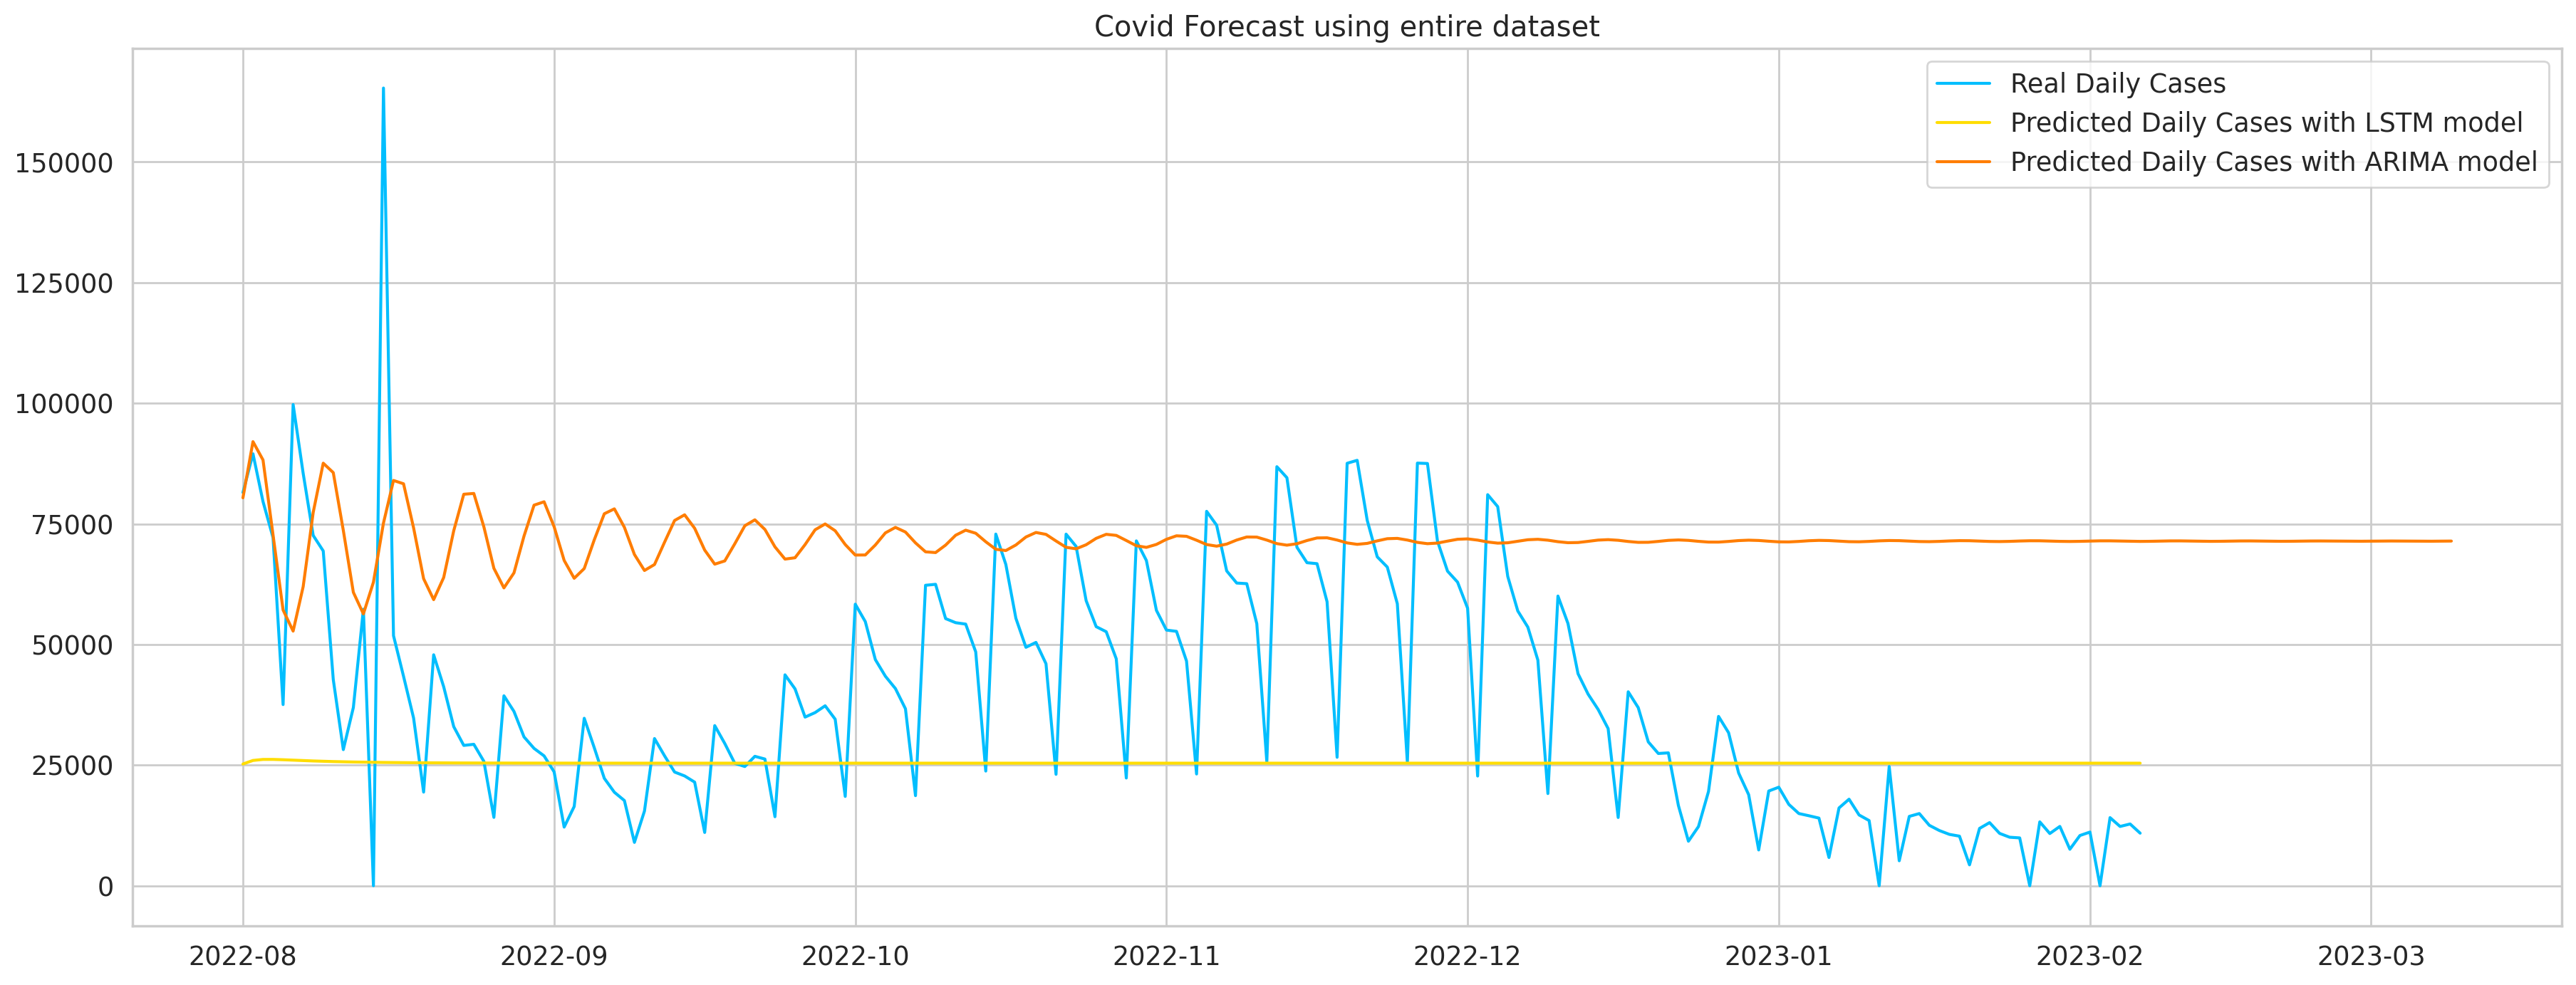

In [ ]:
plt.figure(figsize=(22,8))
plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(true_cases)],
  true_cases,
  label='Real Daily Cases'
)

plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(true_cases)],
  predicted_cases,
  label='Predicted Daily Cases with LSTM model'
)

plt.plot(forecast,label = "Predicted Daily Cases with ARIMA model")

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=7))
plt.title("Covid Forecast using entire dataset")
plt.legend()

In [ ]:
## MAE for LSTM model with entire dataset
MAE(true_cases, predicted_cases)

21456.256033939906

In [ ]:
## MAE for ARIMA model with entire dataset
MAE(np.array(test_data1), np.array(forecast))

37042.39653887995

* The results from models using the entire datasets are worse, even though the size of the training datasets has been increased.\
 Increasing the size of the training dataset generally helps improve model performance by providing more data for the model to learn from, which can lead to a decrease in metrics like RMSE.\
However, the dynamics of the COVID-19 pandemic can change rapidly due to new variants, government policies, public behavior, and vaccination rates. Historical data may not always capture these changes effectively, leading to inaccurate predictions despite a larger dataset.\
 In summary, while increasing the training dataset size has the potential to improve model performance, it must be complemented with high-quality, consistent data, appropriate model selection, and consideration of external factors and changing dynamics to achieve lower RMSE in predicting COVID-19 cases.